# Association Rules Mining For Item Pairs

Association analysis using the apriori algorithm to derive rules of the form {A} -> {B}. 

Content largely copied from this excellent [blogpost](https://www.datatheque.com/posts/association-analysis/) by Grace Tenorio.


**Data Sources:**

- `xxx.csv`: blablabla

**Data Output:**

- `xxx.csv`: blablabla

**Changes**

- 2019-07-04: Start project



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Check-basic-data-structure" data-toc-modified-id="Check-basic-data-structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check basic data structure</a></span></li><li><span><a href="#Perpare-data" data-toc-modified-id="Perpare-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Perpare data</a></span></li><li><span><a href="#Define-Association-Rules-Function" data-toc-modified-id="Define-Association-Rules-Function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define Association Rules Function</a></span><ul class="toc-item"><li><span><a href="#Helper-functions-to-the-main-association-rules-function" data-toc-modified-id="Helper-functions-to-the-main-association-rules-function-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Helper functions to the main association rules function</a></span></li><li><span><a href="#Association-rules-function" data-toc-modified-id="Association-rules-function-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Association rules function</a></span></li></ul></li></ul></div>

---

## Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Specials
from itertools import combinations, groupby
from collections import Counter

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
# sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [37]:
# Load data
orders_df = pd.read_csv('data/instacart/order_products__prior.csv')

## Check basic data structure

In [3]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


In [4]:
orders_df.sample(10)

,order_id,product_id,add_to_cart_order,reordered
14355081,1514797,21137,3,1
18005763,1899273,3142,2,1
21149371,2230718,24964,12,1
19944524,2103556,18778,19,0
5518615,582489,45747,17,1
9781965,1032860,45504,4,1
8542229,901771,48119,15,1
4758826,502275,14309,25,0
27596571,2910173,27156,9,1
22483246,2371420,37192,7,0


In [38]:
print("Number of unique orders: ", orders_df['order_id'].nunique())
print("Number of unique products: ", orders_df['product_id'].nunique())
print("Mean number of products per order: ", round(len(orders_df) / orders_df['order_id'].nunique(),0))

Number of unique orders:  3214874
Number of unique products:  49677
Mean number of products per order:  10.0


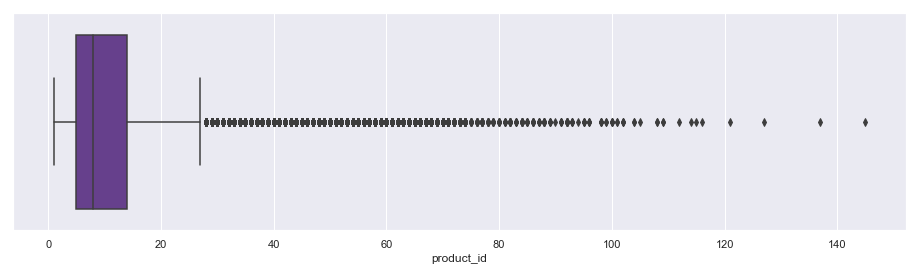

In [34]:
"""Visualize distribution of number of products per order"""
order_sizes = orders_df.groupby('order_id')['product_id'].count()
plt.figure(figsize=(16,4))
sns.boxplot(order_sizes, color=color, orient='h');

## Perpare data

Convert order data into format expected by the association rules function

In [47]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders_df.set_index('order_id')['product_id'].rename('item_id')

assert orders.index.nunique() == orders_df['order_id'].nunique()
assert orders.nunique() == orders_df['product_id'].nunique()

# Check results
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

## Define Association Rules Function

### Helper functions to the main association rules function

In [ ]:
def freq(iterable):
    """Return frequency counts for items and item pairs"""
    
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
    
def order_count(order_item):
    """Return number of unique orders"""
    
    return len(set(order_item.index))



def get_item_pairs(order_item):
    """Return generator that yields item pairs, one at a time"""
    
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            


def merge_item_stats(item_pairs, item_stats):
    """Returns frequency and support associated with item"""
    
    return (item_pairs
                .merge(item_stats.rename(
                    columns={'freq': 'freqA', 
                             'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(
                    columns={'freq': 'freqB', 
                             'support': 'supportB'}), left_on='item_B', right_index=True))



def merge_item_name(rules, item_name):
    """Return name associated with item"""
    
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), 
                       left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), 
                       left_on='item_B', right_on='item_id'))
    return rules[columns]               

### Association rules function